#### Brian Huang
---

# Predict if an Officer is fired or not from News Articles on Recent Shootings
---

### Loading Packages

In [1]:
# dataframe
import numpy as np
import pandas as pd

# text analysis and manipulation
import urllib2 as ulb
import nltk
from textblob import TextBlob as tb
from textblob.sentiments import NaiveBayesAnalyzer as NBA
from bs4 import BeautifulSoup as bfs

# Machine Learning packages
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
import sklearn.preprocessing as pps

# k-fold validation
from sklearn.cross_validation import KFold
from sklearn.metrics import f1_score, confusion_matrix

# graphing
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

---

### Data Loading and Pre-Processing

In [2]:
#reading in the data set
shooting = pd.read_csv("./Data/police.csv")

In [3]:
#checking to see what data I have
shooting.head()

,Name,Cause of Death,Date of Death,State,City,Gender,Age,Race,Photo,News Story,Month of Death,Year of Death,Was the deceased armed?,Did the deceased have priors?,Was the officer involved fired or suspended?
0,Aaron Alexis,Shooting,16/09/2013,Texas,"Fort Worth, Texas",Male,34,Black,http://www.killedbypolice.net/victims/130475.jpg,http://www.washingtonpost.com/politics/aaron-a...,September 2013,2013,Yes,Yes,Unclear
1,Aaron McDaniels,Shooting,20/08/2013,Pennsylvania,"North Philadelphia, Pennsylvania",Male,19,Unknown,NaN,http://www.nbcphiladelphia.com/news/local/Man-...,August 2013,2013,Yes,Yes,Yes
2,Abdul Kamal,Shooting,11/11/2013,New Jersey,NaN,Male,30,Black,http://www.killedbypolice.net/victims/130638.jpg,http://www.dailyjournal.net/view/story/a4d38b3...,November 2013,2013,Unclear,Unclear,Unclear
3,Adam Ignatz Bosch,Shooting,07/07/2013,California,NaN,Male,29,White,http://www.killedbypolice.net/victims/130255.jpg,http://www.pe.com/local-news/riverside-county/...,July 2013,2013,Unclear,Unclear,Unclear
4,Adolfo Ramirez,Shooting,23/11/2013,California,"Riverside, California",Male,37,Latino,NaN,http://www.nbclosangeles.com/news/local/Office...,November 2013,2013,Yes,Unclear,Unclear


In [4]:
shooting.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2355 entries, 0 to 2354
Data columns (total 15 columns):
Name                                            2355 non-null object
Cause of Death                                  2355 non-null object
Date of Death                                   2355 non-null object
State                                           2355 non-null object
City                                            2171 non-null object
Gender                                          2354 non-null object
Age                                             2279 non-null float64
Race                                            2353 non-null object
Photo                                           1512 non-null object
News Story                                      2309 non-null object
Month of Death                                  2354 non-null object
Year of Death                                   2355 non-null int64
Was the deceased armed?                         2268 non-null obj

In [5]:
#renaming the column News Story to News for easier access for future references
shooting.rename(columns={'News Story':'News'}, inplace = True)
shooting.rename(columns={'Was the officer involved fired or suspended?': 'Fired'}, inplace = True)
shooting.rename(columns={'Was the deceased armed?':'Armed'}, inplace = True)
shooting.rename(columns={'Did the deceased have priors?':'Priors'}, inplace = True)

In [6]:
#dropping null values to reduce confusion
shooting.dropna(inplace = True)

In [81]:
#Checking my current data
shooting.head()

,Name,Cause of Death,Date of Death,State,City,Gender,Age,Race,Photo,News,Month of Death,Year of Death,Armed,Priors,Fired
0,Aaron Alexis,Shooting,16/09/2013,Texas,"Fort Worth, Texas",Male,34,Black,http://www.killedbypolice.net/victims/130475.jpg,http://www.washingtonpost.com/politics/aaron-a...,September 2013,2013,Yes,Yes,Unclear
6,Adrian Montesano,Shooting,10/12/2013,Florida,"Miami-Dade, Florida",Male,27,Latino,http://www.killedbypolice.net/victims/130722.jpg,http://www.miamiherald.com/2013/12/10/3809575/...,December 2013,2013,Yes,Yes,Unclear
8,Ajani Mitchell,Shooting,25/05/2013,South Carolina,"Columbia, South Carolina",Male,21,Black,http://www.killedbypolice.net/victims/130085.jpg,http://www.wistv.com/story/22424504/man-killed...,May 2013,2013,Yes,Unclear,Unclear
10,Albert Manuel Vasquez,Shooting,28/11/2013,California,"San Jose, California",Male,42,Latino,http://www.killedbypolice.net/victims/130690.jpg,http://www.mercurynews.com/crime-courts/ci_246...,November 2013,2013,Unclear,Unclear,Yes
14,Alexander Jamar Marion,Shooting,29/09/2013,North Carolina,"Asheville, North Carolina",Male,19,Black,http://www.killedbypolice.net/victims/130508.jpg,http://www.citizen-times.com/article/20130929/...,September 2013,2013,Yes,Unclear,Unclear


In [82]:
shooting.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1333 entries, 0 to 2353
Data columns (total 15 columns):
Name              1333 non-null object
Cause of Death    1333 non-null object
Date of Death     1333 non-null object
State             1333 non-null object
City              1333 non-null object
Gender            1333 non-null object
Age               1333 non-null float64
Race              1333 non-null object
Photo             1333 non-null object
News              1333 non-null object
Month of Death    1333 non-null object
Year of Death     1333 non-null int64
Armed             1333 non-null object
Priors            1333 non-null object
Fired             1333 non-null object
dtypes: float64(1), int64(1), object(13)
memory usage: 166.6+ KB


In [83]:
#obtaining all URLs for news articles so I can access them later
urls = [item for item in shooting.News]

---

### My Little Web Scrapper!

In [106]:
'''Courtesy to Lee for helping me with Try Except
making all my dreams possible'''


#initialize a data structure to store all the headlines
headlines = {}
#looping through urls and get headlines
for i, url in enumerate(urls):
    #sending requet
    req = ulb.Request(url)
    #open the url
    try:
        response = ulb.urlopen(req)
    except:
        print '{} -- generated response error'.format(url)
    #reading in the contents in HTML
    article = response.read()
    #make it into beautifulsoup object
    soup = bfs(article)
    #grabbing headlines and store it into the data structure
    if soup.title is None:
        continue
    else:
        headlines[i] = soup.title.text

http://www.wistv.com/story/22424504/man-killed-by-police-after-returning-to-mothers-home-with-weapon -- generated response error
http://www.foxcarolina.com/story/23689681/shooting-reported-in-anderson-county -- generated response error
http://www.okcfox.com/story/24316925/police-off-duty-ohp-officer-shoots-intruder -- generated response error
http://archive.thv11.com/(X(1)A(SlTUQo8OzQEkAAAAMDE0MDdiN2UtNDBlMC00ZjQwLTkxMWEtMmYwNDRiNDRkMWE2jqBWVN2S1ECjhPUK4T-4xLsbIiI1))/news/article/270495/2/Man-in-officer-involved-shooting-was-Brandon-Rennie-Turner---a-sex-offender-wanted-for-robberies-attempted-murder -- generated response error
http://www.wwaytv3.com/2013/10/13/man-wanted-for-shooting-deputy-killed -- generated response error
http://www.todaystmj4.com/news/local/207993631.html -- generated response error
http://www.wthr.com/story/23090138/2013/08/09/police-action-shooting-on-southside -- generated response error
http://newsok.com/okc-police-waiting-to-release-name-of-victim-killed-in-t

In [107]:
# checking data length
len(headlines)

1086

In [130]:
#adding the headlines into dataframe
shooting['headlines'] = pd.Series(headlines)

In [136]:
#dropping null values again
shooting.dropna(inplace = True)

In [81]:
#saving the dataset as a new csv file to avoid re-running the web scrapper
shooting.to_csv("Data/new_police.csv", encoding='utf-8')

---

### EDA and Engineering

In [13]:
# New Data set (processed)
new_shooting = pd.read_csv("./data/new_police.csv")

In [14]:
len(new_shooting)

569

In [10]:
new_shooting_less = new_shooting[new_shooting['Fired'] != 'Unclear']

In [11]:
len(new_shooting_less)

210

In [12]:
new_shooting_less.head()

,Unnamed: 0,Name,Cause of Death,Date of Death,State,City,Gender,Age,Race,Photo,News,Month of Death,Year of Death,Armed,Priors,Fired,headlines
7,23,Andrea Naharro-Gionet,Shooting,16/11/2013,California,"San Jose, California",Female,61,Native American,http://www.killedbypolice.net/victims/130649.jpg,http://www.mercurynews.com/crime-courts/ci_245...,November 2013,2013,Yes,Unclear,Yes,"Off-duty deputy shoots, kills alleged robber; ..."
8,24,Andrea Rebello,Shooting,18/05/2013,New York,"Mineola, New York",Female,21,White,http://www.killedbypolice.net/victims/130056.jpg,http://www.businessinsider.com/andrea-rebello-...,May 2013,2013,No,Yes,Yes,"Torrance police shoot, kill man suspected of a..."
12,30,Andrew Scott Hoffman,Shooting,27/10/2013,Maryland,"Baltimore, Maryland",Male,27,White,http://www.killedbypolice.net/victims/130598.jpg,http://www.baltimoresun.com/news/maryland/anne...,October 2013,2013,No,No,No,Claims Of Road Rage Between Off-Duty Officer &...
14,32,Andrew Thomas,Shooting,18/07/2013,Florida,"Miramar, Florida",Male,23,Black,http://www.killedbypolice.net/victims/130285.jpg,http://www.nbcmiami.com/news/local/Suspect-Dea...,July 2013,2013,Yes,Yes,Yes,Sheriff: 'Career criminal' killed by deputy af...
16,34,Andy Snider,Shooting,09/12/2013,New Mexico,"Albuquerque, New Mexico",Male,37,White,http://www.killedbypolice.net/victims/130719.jpg,http://krqe.com/2015/04/08/lawsuit-filed-in-po...,December 2013,2013,Yes,Unclear,No,Saratoga: Man shot and killed after attacking ...


In [188]:
new_shooting.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 0 to 568
Data columns (total 17 columns):
Unnamed: 0        569 non-null int64
Name              569 non-null object
Cause of Death    569 non-null object
Date of Death     569 non-null object
State             569 non-null object
City              569 non-null object
Gender            569 non-null object
Age               569 non-null float64
Race              569 non-null object
Photo             569 non-null object
News              569 non-null object
Month of Death    569 non-null object
Year of Death     569 non-null int64
Armed             569 non-null object
Priors            569 non-null object
Fired             569 non-null object
headlines         569 non-null object
dtypes: float64(1), int64(2), object(14)
memory usage: 80.0+ KB


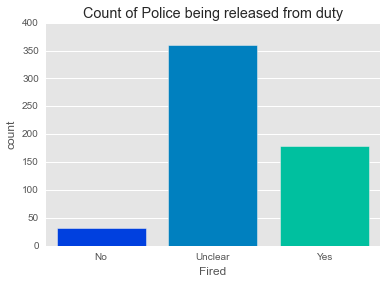

In [189]:
# Producing a plot to check labels

#Checking how many police are fired
plt.title("Count of Police being released from duty");
sns.barplot('Fired', data = new_shooting, palette='winter');

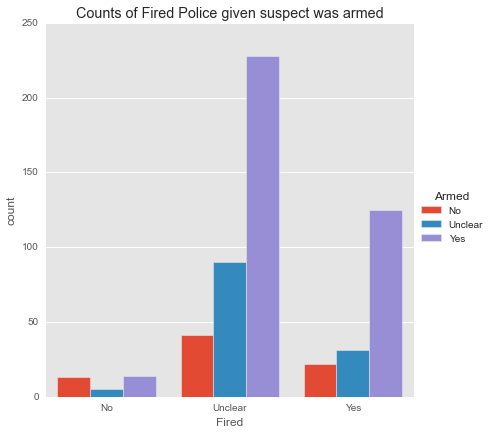

In [190]:
# Police being fired given the suspect is armed
sns.factorplot('Fired', data = new_shooting, hue = 'Armed',size = 6);
sns.plt.title("Counts of Fired Police given suspect was armed");

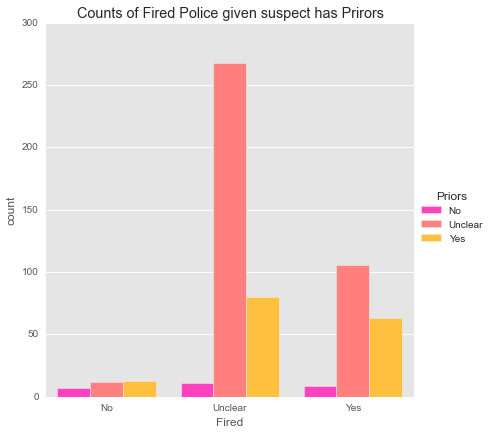

In [191]:
# Police being fired given the suspect has Priors
sns.factorplot('Fired', data = new_shooting, hue = 'Priors', size = 6, palette='spring');
sns.plt.title("Counts of Fired Police given suspect has Prirors");

In [192]:
# Gender representation
new_shooting['Gender'].value_counts()

Male      527
Female     42
dtype: int64

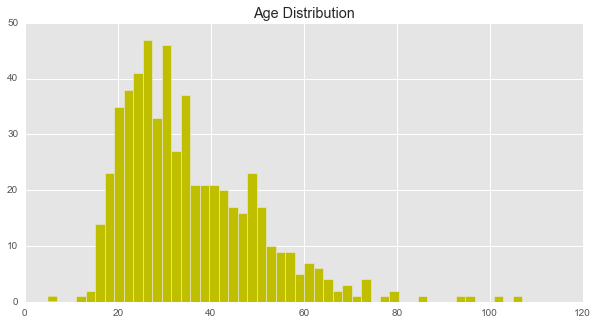

In [193]:
# Age representation
plt.figure(figsize=(10, 5));
plt.hist(new_shooting['Age'], bins = 50, color='y');
plt.title("Age Distribution");

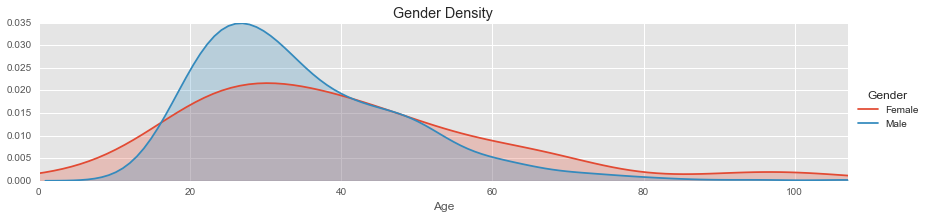

In [194]:
#creating a grid with dataframe
fig = sns.FacetGrid(new_shooting, hue='Gender', aspect=4);
fig.map(sns.kdeplot, 'Age', shade = True);

#set oldest to max age
oldest = new_shooting['Age'].max();

#setting x limits
fig.set(xlim=(0,oldest));

#adding legends
fig.add_legend();

sns.plt.title("Gender Density");

In [195]:
normalize = pps.Normalizer()
race = new_shooting.Race.value_counts().astype(float)
race

White              275
Black              174
Latino              76
Unknown             34
Native American      4
Asian                3
Other                3
dtype: float64

In [196]:
norm_race = normalize.fit_transform(race)
norm_race_df = pd.DataFrame(norm_race, columns=['White','Black','Latino','Unknown','Native_American','Asian','Other'])
norm_race_df

,White,Black,Latino,Unknown,Native_American,Asian,Other
0,0.818558,0.517924,0.22622,0.101203,0.011906,0.00893,0.00893


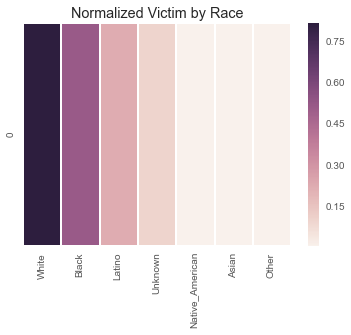

In [197]:
# pie chart for number of race
sns.heatmap(norm_race_df);
sns.plt.Figure(figsize=(20,10));
sns.plt.title("Normalized Victim by Race");

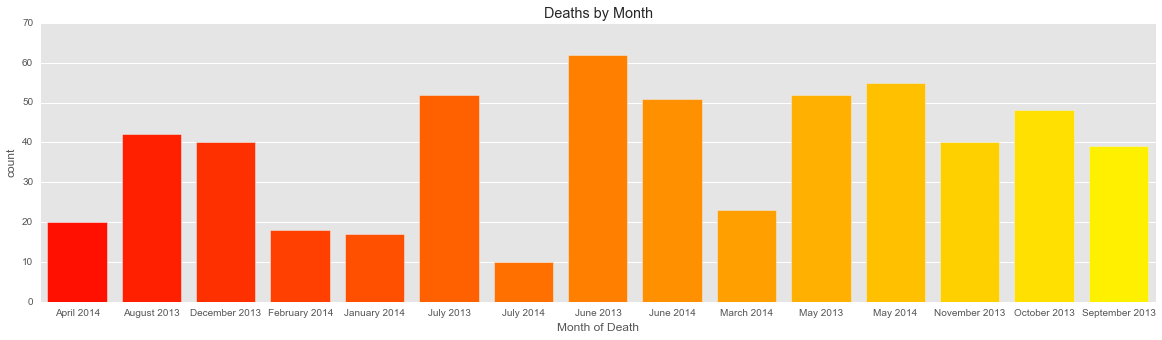

In [198]:
sns.plt.figure(figsize = (20,5));
sns.barplot(new_shooting['Month of Death'], 
            palette = 'autumn');
sns.plt.title("Deaths by Month");

In [199]:
# Creating a normalizer object
normalize = pps.Normalizer()
# converting state count into floats for normalization
state = new_shooting.State.value_counts().astype(float)

In [200]:
# getting the col names
col = list(state.index)

In [201]:
# normalizing the state count
norm_state = normalize.fit_transform(state)
# making it into a dataframe
norm_state_df = pd.DataFrame(norm_state, columns=col)
# checking it
norm_state_df

,California,Texas,Florida,Pennsylvania,North Carolina,Ohio,New York,Arizona,Colorado,Illinois,...,District of Columbia,Nebraska,New Hampshire,Maine,Idaho,Rhode Island,Alaska,South Dakota,North Dakota,Vermont
0,0.636941,0.419632,0.389658,0.187336,0.172349,0.164855,0.149868,0.142375,0.104908,0.104908,...,0.014987,0.014987,0.014987,0.014987,0.007493,0.007493,0.007493,0.007493,0.007493,0.007493


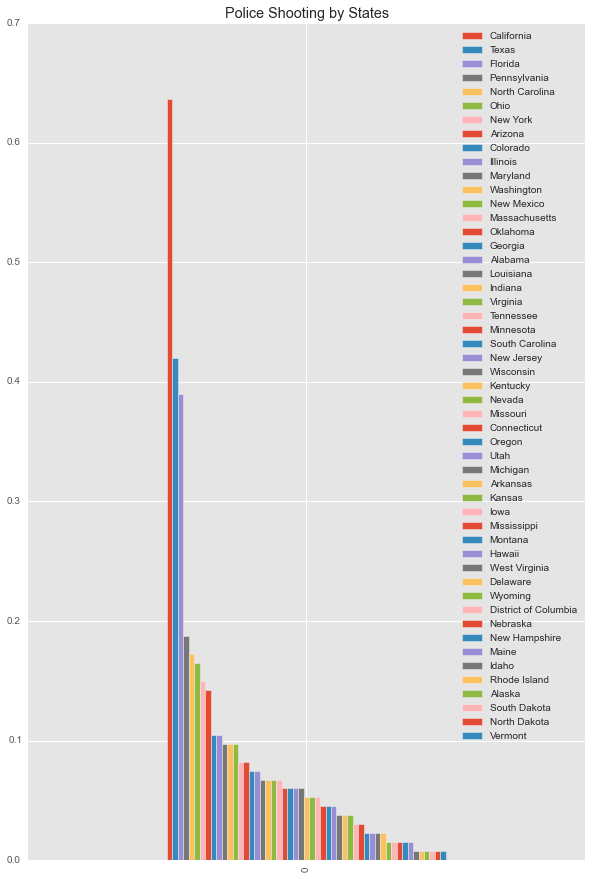

In [202]:
# plotting normalized kill by state
norm_state_df.plot(kind = 'bar', title = "Police Shooting by States", figsize = (10,15));

In [203]:
# make data frame into a list for traversing
headline_list = new_shooting.headlines.tolist()

In [204]:
# creating objects to store objectivity and polarity
obj = {}
polarity = {}
# looping through my headlines
for i, item in enumerate(headline_list):
    # creating my textblob for sentiment analysis
    test = tb(item)
    # try except to catch error
    try:
        # if no error, I store the objectivity and polarity
        # values to obj and polarity
        obj[i] = test.sentiment[1]
        polarity[i] = test.sentiment[0]
    # else...
    except:
        # I look at the indices where my errors occured
        print "error at: ", i

error at:  12
error at:  19
error at:  35
error at:  38
error at:  41
error at:  67
error at:  79
error at:  86
error at:  88
error at:  130
error at:  173
error at:  178
error at:  186
error at:  205
error at:  211
error at:  212
error at:  222
error at:  231
error at:  244
error at:  275
error at:  308
error at:  361
error at:  385
error at:  395
error at:  410
error at:  432
error at:  496
error at:  515
error at:  534
error at:  555
error at:  556


#### Key: polarity is a float within the range [-1.0, 1.0] and subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [205]:
# adding objectivity and polarity to the data frame for analysis
new_shooting['Objectivity'] = pd.Series(obj)
new_shooting['Polarity'] = pd.Series(polarity)

In [206]:
# now, dropping the columns I don't need
new_shooting.drop('Photo', axis = 1, inplace = True)
new_shooting.drop('Year of Death', axis = 1, inplace = True)
new_shooting.drop('News', axis = 1, inplace = True)
new_shooting.drop('Name', axis = 1, inplace = True)
new_shooting.drop('Cause of Death', axis = 1, inplace = True)
new_shooting.drop('Date of Death', axis = 1, inplace = True)
new_shooting.drop('City', axis = 1, inplace = True)
new_shooting.drop('Month of Death', axis = 1, inplace = True)
new_shooting.drop('headlines', axis = 1, inplace = True)

In [207]:
new_shooting.head()

,State,Gender,Age,Race,Armed,Priors,Fired,Objectivity,Polarity
0,Texas,Male,34,Black,Yes,Yes,Unclear,0.4,-0.2
1,Florida,Male,27,Latino,Yes,Yes,Unclear,0.0,0.0
2,South Carolina,Male,21,Black,Yes,Unclear,Unclear,0.4,-0.2
3,North Carolina,Male,19,Black,Yes,Unclear,Unclear,0.0,-0.2
4,Idaho,Male,26,White,Unclear,Unclear,Unclear,0.4,-0.2


In [174]:
# checking length
len(new_shooting)

569

In [175]:
# drop the NaN values
new_shooting.dropna(inplace = True)

In [176]:
# checking how much data I have lost
len(new_shooting)

538

---

### Modeling

In [208]:
# preprocessing: making Gender Binary
new_shooting['Gender'] = 1. * (new_shooting['Gender'] == 'Male')

In [209]:
# a function that processes the data into 3 classifications
def preprocess(data):
    if data == "Yes":
        return 1
    elif data == "No":
        return 0
    elif data == "Unclear":
        return -1

In [210]:
# applying my function to my dataframe
new_shooting['Armed'] = new_shooting['Armed'].apply(preprocess)
new_shooting['Priors'] = new_shooting['Priors'].apply(preprocess)
new_shooting['Fired'] = new_shooting['Fired'].apply(preprocess)

In [211]:
# save it as another csv
new_shooting.to_csv("Data/new_police_cleaned.csv", encoding='utf-8')

In [244]:
cleaned_data = pd.read_csv("./Data/new_police_cleaned.csv")

In [245]:
cleaned_data.drop('Unnamed: 0', axis = 1, inplace = True)

In [246]:
cleaned_data.head()

,State,Gender,Age,Race,Armed,Priors,Fired,Objectivity,Polarity
0,Texas,1,34,Black,1,1,-1,0.4,-0.2
1,Florida,1,27,Latino,1,1,-1,0.0,0.0
2,South Carolina,1,21,Black,1,-1,-1,0.4,-0.2
3,North Carolina,1,19,Black,1,-1,-1,0.0,-0.2
4,Idaho,1,26,White,-1,-1,-1,0.4,-0.2


In [247]:
cleaned_data.dropna(inplace = True)

In [248]:
cleaned_data_dummy = pd.get_dummies(cleaned_data)

In [249]:
cleaned_data_dummy.head()

,Gender,Age,Armed,Priors,Fired,Objectivity,Polarity,State_Alabama,State_Alaska,State_Arizona,...,State_West Virginia,State_Wisconsin,State_Wyoming,Race_Asian,Race_Black,Race_Latino,Race_Native American,Race_Other,Race_Unknown,Race_White
0,1,34,1,1,-1,0.4,-0.2,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,27,1,1,-1,0.0,0.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,21,1,-1,-1,0.4,-0.2,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,19,1,-1,-1,0.0,-0.2,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,26,-1,-1,-1,0.4,-0.2,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [250]:
feat_col = list(cleaned_data_dummy.drop('Fired', axis = 1))

In [251]:
# predictators
features = cleaned_data_dummy[feat_col]
# predicted
label = cleaned_data_dummy['Fired']

In [252]:
# creating train test split with identified sizes
x_train, x_test, y_train, y_test = train_test_split(features, label, train_size = 0.8, test_size = 0.2)

###Modeling - Random Forest

In [253]:
# initialize my RFC
RF_model = RandomForestClassifier(n_estimators = 100)

In [254]:
RF_model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [255]:
rf_pred = RF_model.predict(x_test)

In [256]:
RF_model.score(x_test, y_test,)

0.56481481481481477

In [258]:
RF_cm = confusion_matrix(y_test, rf_pred)

In [262]:
f1_score(y_test, rf_pred, average = 'weighted')

0.51956068622735296

In [265]:
# Stoled this from sklearn website at 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [266]:
RF_cm

array([[48,  0, 12],
       [ 7,  0,  3],
       [25,  0, 13]])

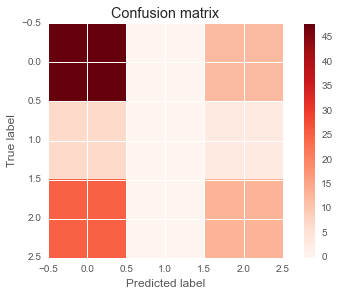

In [267]:
plot_confusion_matrix(RF_cm, cmap = plt.cm.Reds)

---

### Modeling - AdaBoost

In [496]:
# initialize AdaBoost
model_ada = AdaBoostClassifier(n_estimators = 100)

In [497]:
model_ada.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None)

In [498]:
ada_pred = model_ada.predict(x_test)

In [499]:
model_ada.score(x_test, y_test)

0.58333333333333337

In [500]:
f1_score(y_test, ada_pred, average=None)

array([ 0.72955975,  0.36363636,  0.13043478])

In [501]:
ada_cm = confusion_matrix(y_test, pred)

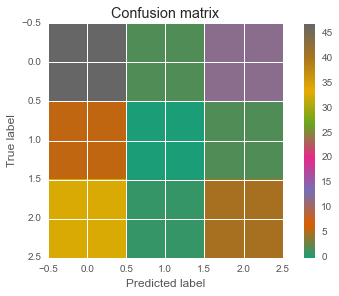

In [503]:
plot_confusion_matrix(ada_cm, cmap = plt.cm.Dark2)

---

### Modeling - SVM

In [505]:
# initialize SVM
model_SVM = SVC(kernel='poly')

In [506]:
model_SVM.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [507]:
SVM_pred = model_SVM.predict(x_test)

In [508]:
model_SVM.score(X_test, Y_test)

0.63888888888888884

In [509]:
f1_score(y_test, SVM_pred, average = None)

array([ 0.72189349,  0.        ,  0.        ])

In [510]:
SVM_cm = confusion_matrix(y_test, pred)

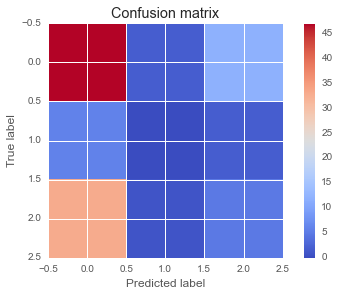

In [512]:
plot_confusion_matrix(SVM_cm, cmap = plt.cm.coolwarm)

### Scaled SVM

In [513]:
scaled_feature = pps.scale(features)

In [514]:
X_train, X_test, Y_train, Y_test = train_test_split(scaled_feature, label, train_size = 0.8, test_size = 0.2)

In [515]:
scaled_model = model_SVM.fit(X_train, Y_train)

In [516]:
pred_scaled = scaled_model.predict(X_test)

In [517]:
scaled_model.score(X_test, Y_test)

0.62962962962962965

In [518]:
f1_score(Y_test, pred_scaled, average = None)

array([ 0.75903614,  0.        ,  0.22222222])

In [519]:
scaled_SVM_cm = confusion_matrix(Y_test, pred_scaled)

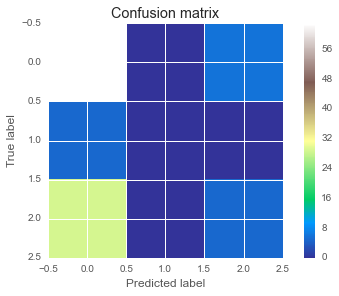

In [521]:
plot_confusion_matrix(scaled_SVM_cm, cmap = plt.cm.terrain)

---

### Alternative Engineering and Modeling

In [409]:
new_headline = new_shooting.headlines

In [419]:
Classification = {}
Positive = {}
Negative = {}
for i, item in enumerate(new_headline):
    # creating my textblob for sentiment analysis
    test = tb(item, analyzer=NBA())
    # try except to catch error
    try:
        # if no error, I store the objectivity and polarity
        # values to obj and polarity
        Classification[i] = test.sentiment[0]
        Positive[i] = test.sentiment[1]
        Negative[i] = test.sentiment[2]
    # else...
    except:
        # I look at the indices where my errors occured
        print "error at: ", i

In [523]:
new_shooting["Classification"] = pd.Series(Classification)
new_shooting["Positive"] = pd.Series(Positive)
new_shooting["Negative"] = pd.Series(Negative)

In [532]:
new_shooting.head()

,Unnamed: 0,Name,Cause of Death,Date of Death,State,City,Gender,Age,Race,Month of Death,Armed,Priors,Fired,headlines,Objectivity,Polarity,Classification,Positive,Negative
0,0,Aaron Alexis,Shooting,16/09/2013,Texas,"Fort Worth, Texas",1,34,Black,September 2013,1,1,-1,"Aaron Alexis, 34, is dead gunman in Navy Yard...",0.4,-0.2,neg,0.204408,0.795592
1,6,Adrian Montesano,Shooting,10/12/2013,Florida,"Miami-Dade, Florida",1,27,Latino,December 2013,1,1,-1,FBI agent uses lethal force in N.O. East shooting,0.0,0.0,neg,0.403840,0.596160
2,8,Ajani Mitchell,Shooting,25/05/2013,South Carolina,"Columbia, South Carolina",1,21,Black,May 2013,1,-1,-1,San Jose: Deputies kill knife-wielding woman; ...,0.4,-0.2,neg,0.387235,0.612765
3,14,Alexander Jamar Marion,Shooting,29/09/2013,North Carolina,"Asheville, North Carolina",1,19,Black,September 2013,1,-1,-1,"Man shot, killed by police serving warrant in ...",0.0,-0.2,neg,0.198844,0.801156
4,15,Alexander L. Mandarino,Shooting,12/06/2013,Idaho,"Idaho, Idaho",1,26,White,June 2013,-1,-1,-1,Suspect Dead After Deputy-Involved Shooting in...,0.4,-0.2,pos,0.835603,0.164397


In [533]:
new_shooting.dropna(inplace=True)

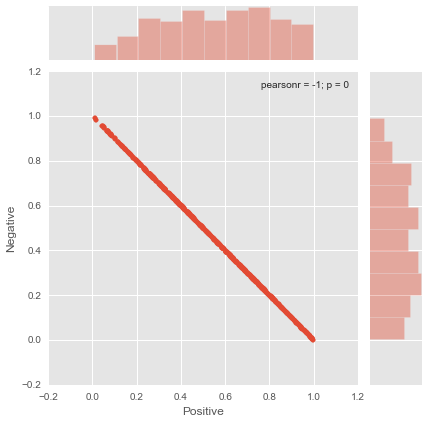

In [534]:
sns.jointplot(new_shooting.Positive, new_shooting.Negative);

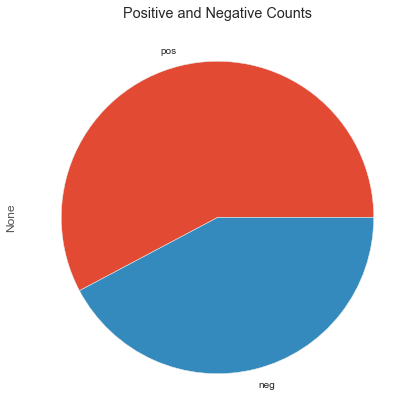

In [535]:
new_shooting.Classification.value_counts().plot(kind = "pie", 
                                                title="Positive and Negative Counts", 
                                                figsize = (7,7));

In [558]:
features_two = new_shooting[['Gender','Armed','Priors','Objectivity','Polarity','Positive','Negative']]
label_two = new_shooting['Fired']

In [559]:
xtrain, xtest, ytrain, ytest = train_test_split(features_two, label_two, train_size = 0.8, test_size = 0.2)

### Random Forest - Take Two
---

In [560]:
RF_model_two = RandomForestClassifier(n_estimators=100)

In [561]:
RF_model_two.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [562]:
pred_class = RF_model_two.predict(xtest)

In [563]:
RF_model_two.score(xtest, ytest)

0.62745098039215685

In [564]:
f1_score(ytest, pred_class, average=None)

array([ 0.73972603,  0.25      ,  0.36      ])

In [570]:
RF_cm_two = confusion_matrix(ytest, pred_class)
RF_cm_two

array([[54,  1, 10],
       [ 5,  1,  0],
       [22,  0,  9]])

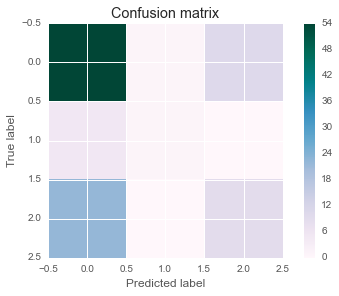

In [569]:
plot_confusion_matrix(RF_cm_two, cmap = plt.cm.PuBuGn)

### AdaBoost - Take Two
---

In [571]:
ada_model_two = AdaBoostClassifier(n_estimators=100)

In [572]:
ada_model_two.fit(xtrain, ytrain)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None)

In [573]:
ada_pred_two = ada_model_two.predict(xtest)

In [574]:
ada_model_two.score(xtest, ytest)

0.60784313725490191

In [575]:
f1_score(ytest, ada_pred_two, average=None)

array([ 0.73103448,  0.22222222,  0.32      ])

In [576]:
ada_confused = confusion_matrix(ytest, ada_pred_two)
ada_confused

array([[53,  2, 10],
       [ 4,  1,  1],
       [23,  0,  8]])

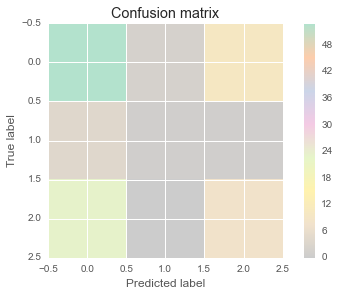

In [577]:
plot_confusion_matrix(ada_confused, cmap = plt.cm.Pastel2_r)

### SVM - Take Two
---

In [583]:
SVM_two = SVC(kernel='poly', C = 0.1)

In [584]:
SVM_two.fit(xtrain, ytrain)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [585]:
svm_pred_two = SVM_two.predict(xtest)

In [586]:
SVM_two.score(xtest, ytest)

0.63725490196078427

In [587]:
f1_score(ytest, svm_pred_two, average=None)

array([ 0.77844311,  0.        ,  0.        ])

In [588]:
svm_two_confused = confusion_matrix(ytest, svm_pred_two)
svm_two_confused

array([[65,  0,  0],
       [ 6,  0,  0],
       [31,  0,  0]])

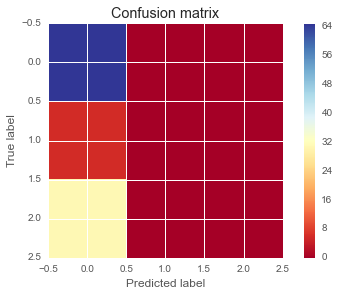

In [589]:
plot_confusion_matrix(svm_two_confused, cmap = plt.cm.RdYlBu)

### SVM Scaled - Take Two

In [590]:
new_feature_two = pps.scale(features_two)

In [591]:
XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(new_feature_two, label_two, train_size = 0.8, test_size = 0.2)

In [592]:
new_svm = SVC(kernel = 'poly')

In [593]:
new_svm.fit(XTRAIN, YTRAIN)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [594]:
new_svm_pred = new_svm.predict(XTEST)

In [595]:
new_svm.score(XTEST, YTEST)

0.61764705882352944

In [597]:
f1_score(YTEST, new_svm_pred, average=None)

array([ 0.75471698,  0.        ,  0.16216216])

In [598]:
new_svm_confused = confusion_matrix(YTEST, new_svm_pred)
new_svm_confused

array([[60,  1,  1],
       [ 7,  0,  0],
       [30,  0,  3]])

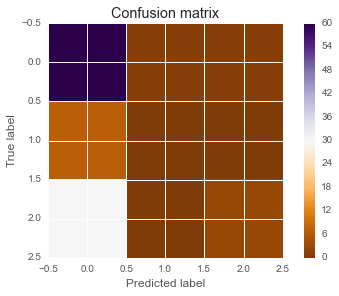

In [599]:
plot_confusion_matrix(new_svm_confused, cmap = plt.cm.PuOr)

### If I had more time.....
---
#####If I had more time, I would:
1. Optimize my webscrapper so I don't lose as much data
2. Incorporate POS tagging to possibly improve my models
3. Create more pretty graphs
4. Figure out how to include States and Race as part of the model
5. Instead of doing headlines, I wanted to work with contents